### How do the perceived income moments correlate with other individual variables 

- this notebook runs regressions to inspects the covariants of individual perceived income moments
  - individual demogrpahics, level of household income, education, etc.
  - job-types, part-time vs full-time, selfemployment, etc. 
  - other expectations: probability of unemployment, other job-related expectations 
- it examiens both nominal and real income growth 


###  1. Loading and cleaning data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
from statsmodels.iolib.summary2 import summary_col

In [2]:
"""
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','png','jpg')
#plt.rcParams['savefig.dpi'] = 75

#plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
#plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
"""

'\nfrom IPython.display import set_matplotlib_formats\nset_matplotlib_formats(\'pdf\',\'png\',\'jpg\')\n#plt.rcParams[\'savefig.dpi\'] = 75\n\n#plt.rcParams[\'figure.autolayout\'] = False\nplt.rcParams[\'figure.figsize\'] = 10, 6\nplt.rcParams[\'axes.labelsize\'] = 18\nplt.rcParams[\'axes.titlesize\'] = 20\n#plt.rcParams[\'font.size\'] = 16\nplt.rcParams[\'lines.linewidth\'] = 2.0\nplt.rcParams[\'lines.markersize\'] = 8\nplt.rcParams[\'legend.fontsize\'] = 14\n\nplt.rcParams[\'text.usetex\'] = True\nplt.rcParams[\'font.family\'] = "serif"\nplt.rcParams[\'font.serif\'] = "cm"\n'

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
dataset = pd.read_stata('../SurveyData/SCE/IncExpSCEProbIndM.dta')   

In [5]:
## panel data 

#dataset.index = dataset[['date','userid']]

In [6]:
## variable list by catogrories 

vars_id = ['userid','date']

moms_nom = ['Q24_var']

moms_real = ['Q24_rvar']

vars_demog = ['D6']   ## level of income, 11 groups 

vars_job = ['Q10_1',  # full-time 
            'Q10_2',  # part-time
            'Q12new'] ## =1 worked for others; = 2 self-employment 

vars_demog_sub = ['Q32',  ## age 
                  'Q33',  ## gender 
                  'Q36']  ## education (1-8 low to high, 9 other)

## these variables are only available for a sub sample 

vars_empexp = ['Q13new']  ## probability of unemployment 

vars_macroexp = ['Q6new',  ## stock market going up 
                 'Q4new']  ## UE goes up 

In [7]:
## subselect variables 

vars_all_reg_long = (vars_id+moms_nom + moms_real + vars_job + 
                     vars_demog + vars_demog_sub + 
                     vars_empexp + vars_macroexp)

## select dataset 

SCEM = dataset[vars_all_reg_long]
SCEM.describe(include='all')

,userid,date,Q24_var,Q24_rvar,Q10_1,Q10_2,Q12new,D6,Q32,Q33,Q36,Q13new,Q6new,Q4new
count,"79,064.00",79064,"47,501.00","44,639.00","79,064.00","79,064.00","51,520.00","67,901.00","11,630.00","11,656.00","11,658.00","45,921.00","78,182.00","78,767.00"
unique,nan,60,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,nan,2013-08-01 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,nan,1769,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
first,nan,2013-06-01 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
last,nan,2018-05-01 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,"70,059,680.73",NaN,5.56,13.47,0.55,0.14,1.13,6.46,50.13,1.52,4.36,14.85,42.80,37.41
std,"20,176.72",NaN,11.12,19.82,0.50,0.34,0.34,2.72,16.58,0.50,1.55,20.41,23.08,22.77
min,"70,000,220.00",NaN,0.28,0.61,0.00,0.00,1.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00
25%,"70,044,346.00",NaN,0.36,1.67,0.00,0.00,1.00,4.00,38.00,1.00,3.00,1.00,25.00,20.00


### 2. Correlation pattern 

In [8]:
SCEM = SCEM.rename(columns = {'D6':'HHinc',
                              'Q13new':'UEprobInd',
                              'Q6new':'Stkprob',
                              'Q4new':'UEprobAgg',
                              'Q10_1':'fulltime',
                              'Q10_2':'parttime',
                              'Q12new':'selfemp',
                              'Q32':'age',
                              'Q33':'gender',
                              'Q36':'educ'})

In [9]:
inc_grp = {1:"<10k",
           2:'<20k',
           3:'<30k',
           4:'<40k',
           5:'<50k',
           6:'<60k',
           7:'<75k',
           8:'<100k',
           9:'<150k',
           10:'<200k',
           11:'>200k'}
cleanup_nums = {'parttime': {0: 'no', 1: 'yes'},
                'fulltime': {0: 'no', 1: 'yes'},
                'selfemp':{1: 'no', 2: 'yes'},
                'gender':{1:'male',2:'female'},
               'HHinc':inc_grp}
SCEM.replace(cleanup_nums,
            inplace = True)

In [10]:
## categorical variables 

vars_cat = ['HHinc','fulltime','parttime','selfemp','gender','userid','date']

for var in vars_cat:
    SCEM[var] = pd.Categorical(SCEM[var])

In [11]:
#pp = sns.pairplot(SCEM)

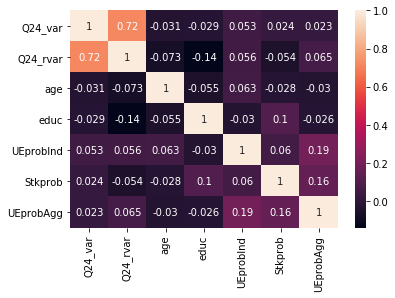

In [12]:
sns.heatmap(SCEM.corr(), annot=True)

###  3. Histograms

In [13]:
## by income group 

fontsize = 80
figsize = (100,50)

"""
for mom in ['var','rvar']:
    for gp in ['HHinc','educ','gender']:
        plt.style.use('seaborn-poster')
        SCEM.boxplot(column=['Q24_'+str(mom)],
                     figsize = figsize,
                     by = gp,
                     patch_artist = True,
                     fontsize = fontsize)
        plt.xlabel(gp,
                   fontsize = fontsize)
        plt.ylabel(mom,
                   fontsize = fontsize)
        plt.ylim(0,40)
        plt.suptitle('')
        plt.title(mom, fontsize= fontsize)
        plt.savefig('../Graphs/ind/boxplot'+str(mom)+'_'+str(gp)+'.jpg')
        
"""

"\nfor mom in ['var','rvar']:\n    for gp in ['HHinc','educ','gender']:\n        plt.style.use('seaborn-poster')\n        SCEM.boxplot(column=['Q24_'+str(mom)],\n                     figsize = figsize,\n                     by = gp,\n                     patch_artist = True,\n                     fontsize = fontsize)\n        plt.xlabel(gp,\n                   fontsize = fontsize)\n        plt.ylabel(mom,\n                   fontsize = fontsize)\n        plt.ylim(0,40)\n        plt.suptitle('')\n        plt.title(mom, fontsize= fontsize)\n        plt.savefig('../Graphs/ind/boxplot'+str(mom)+'_'+str(gp)+'.jpg')\n        \n"

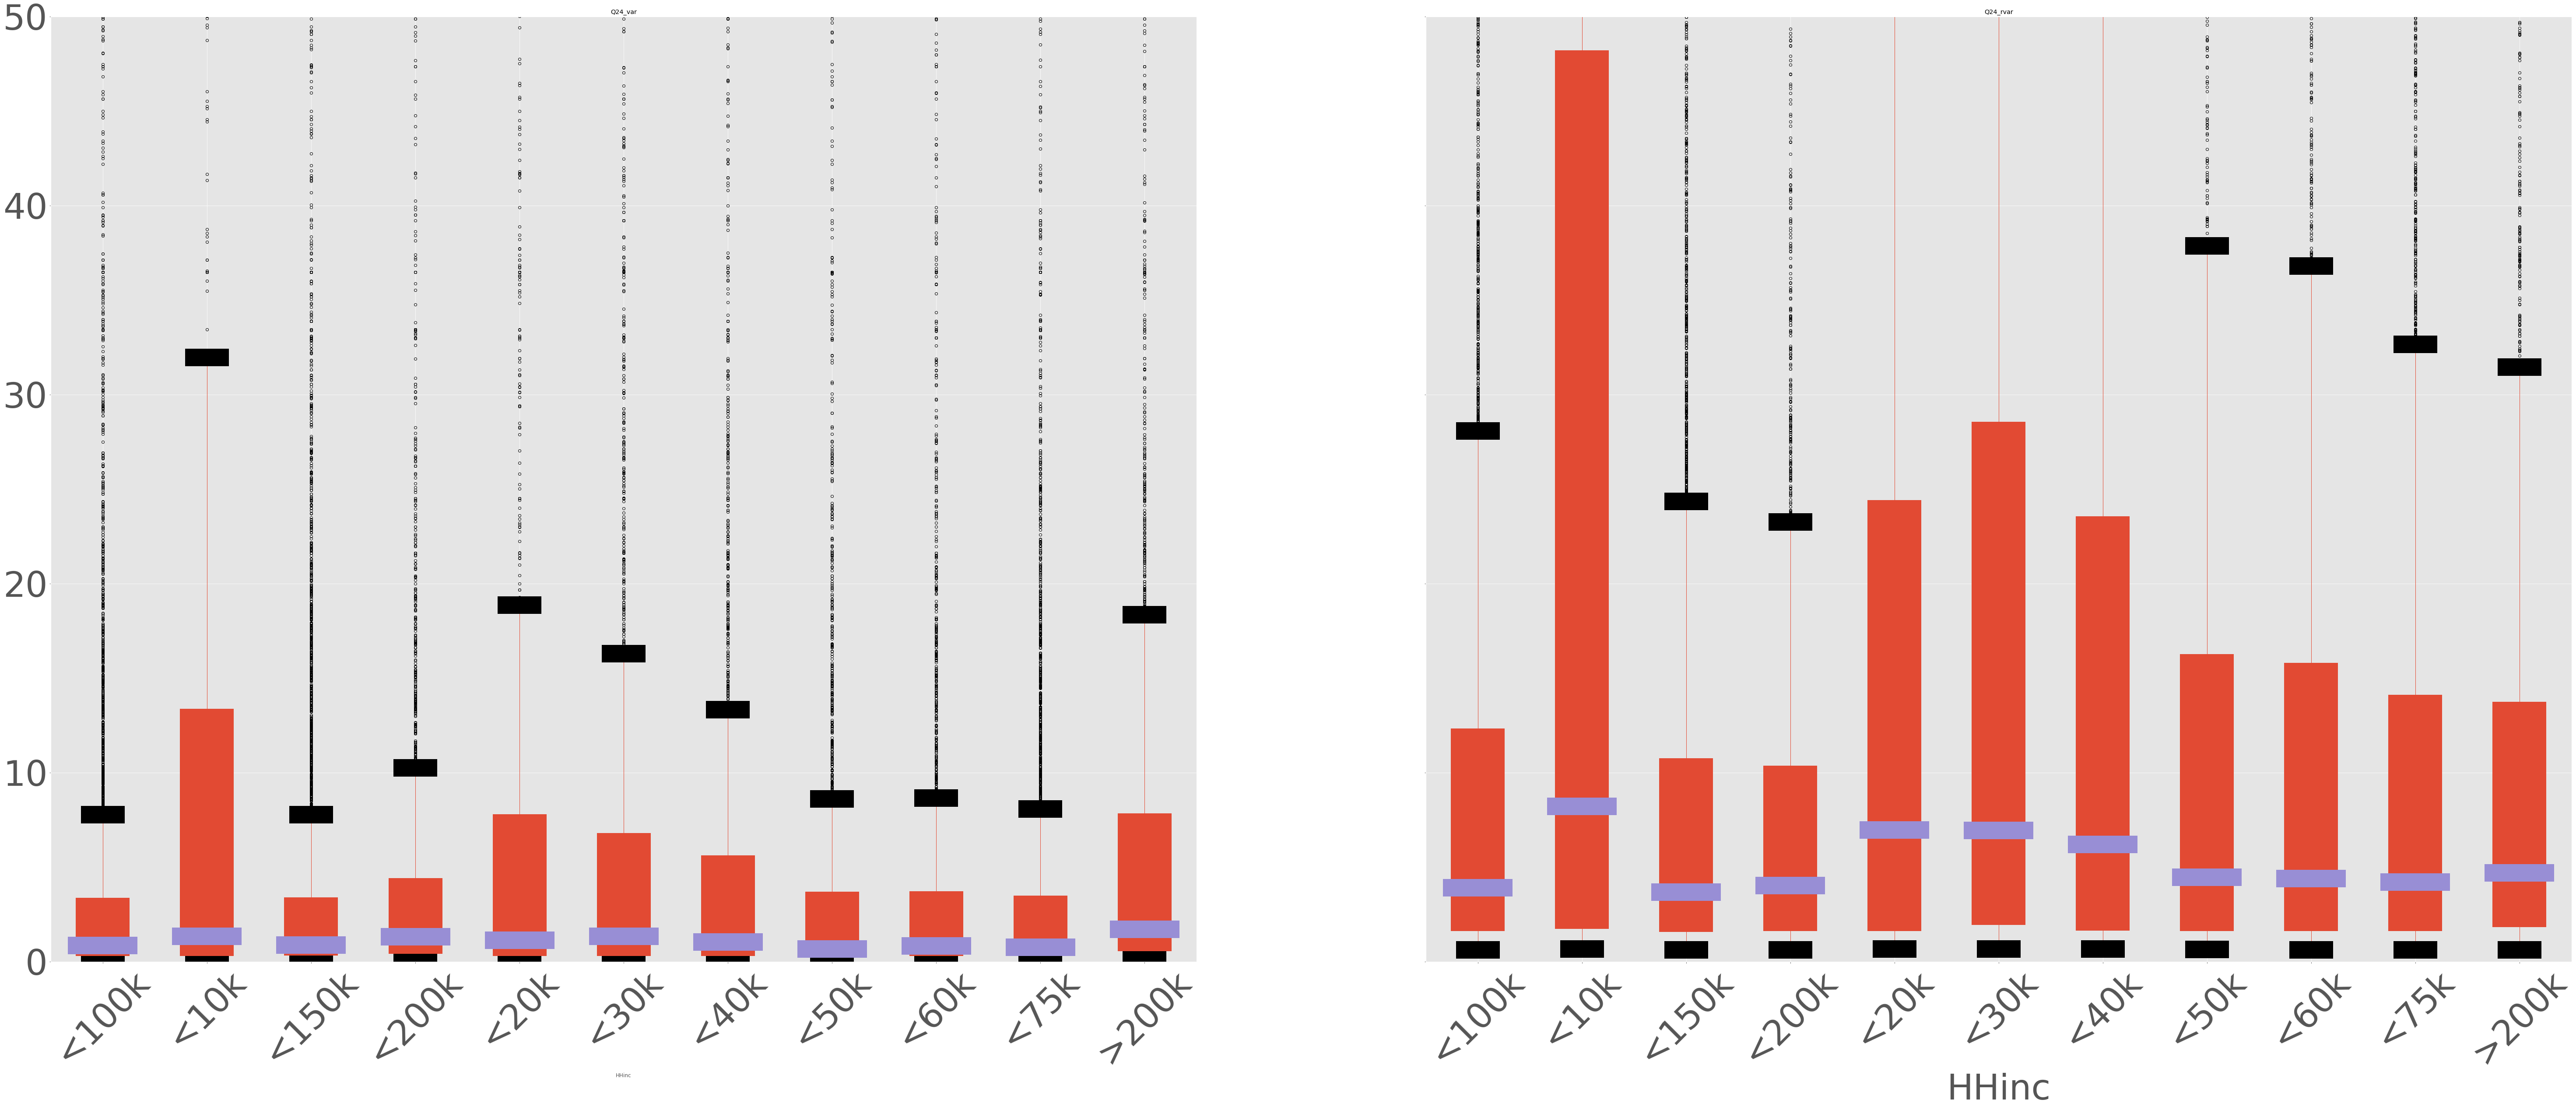

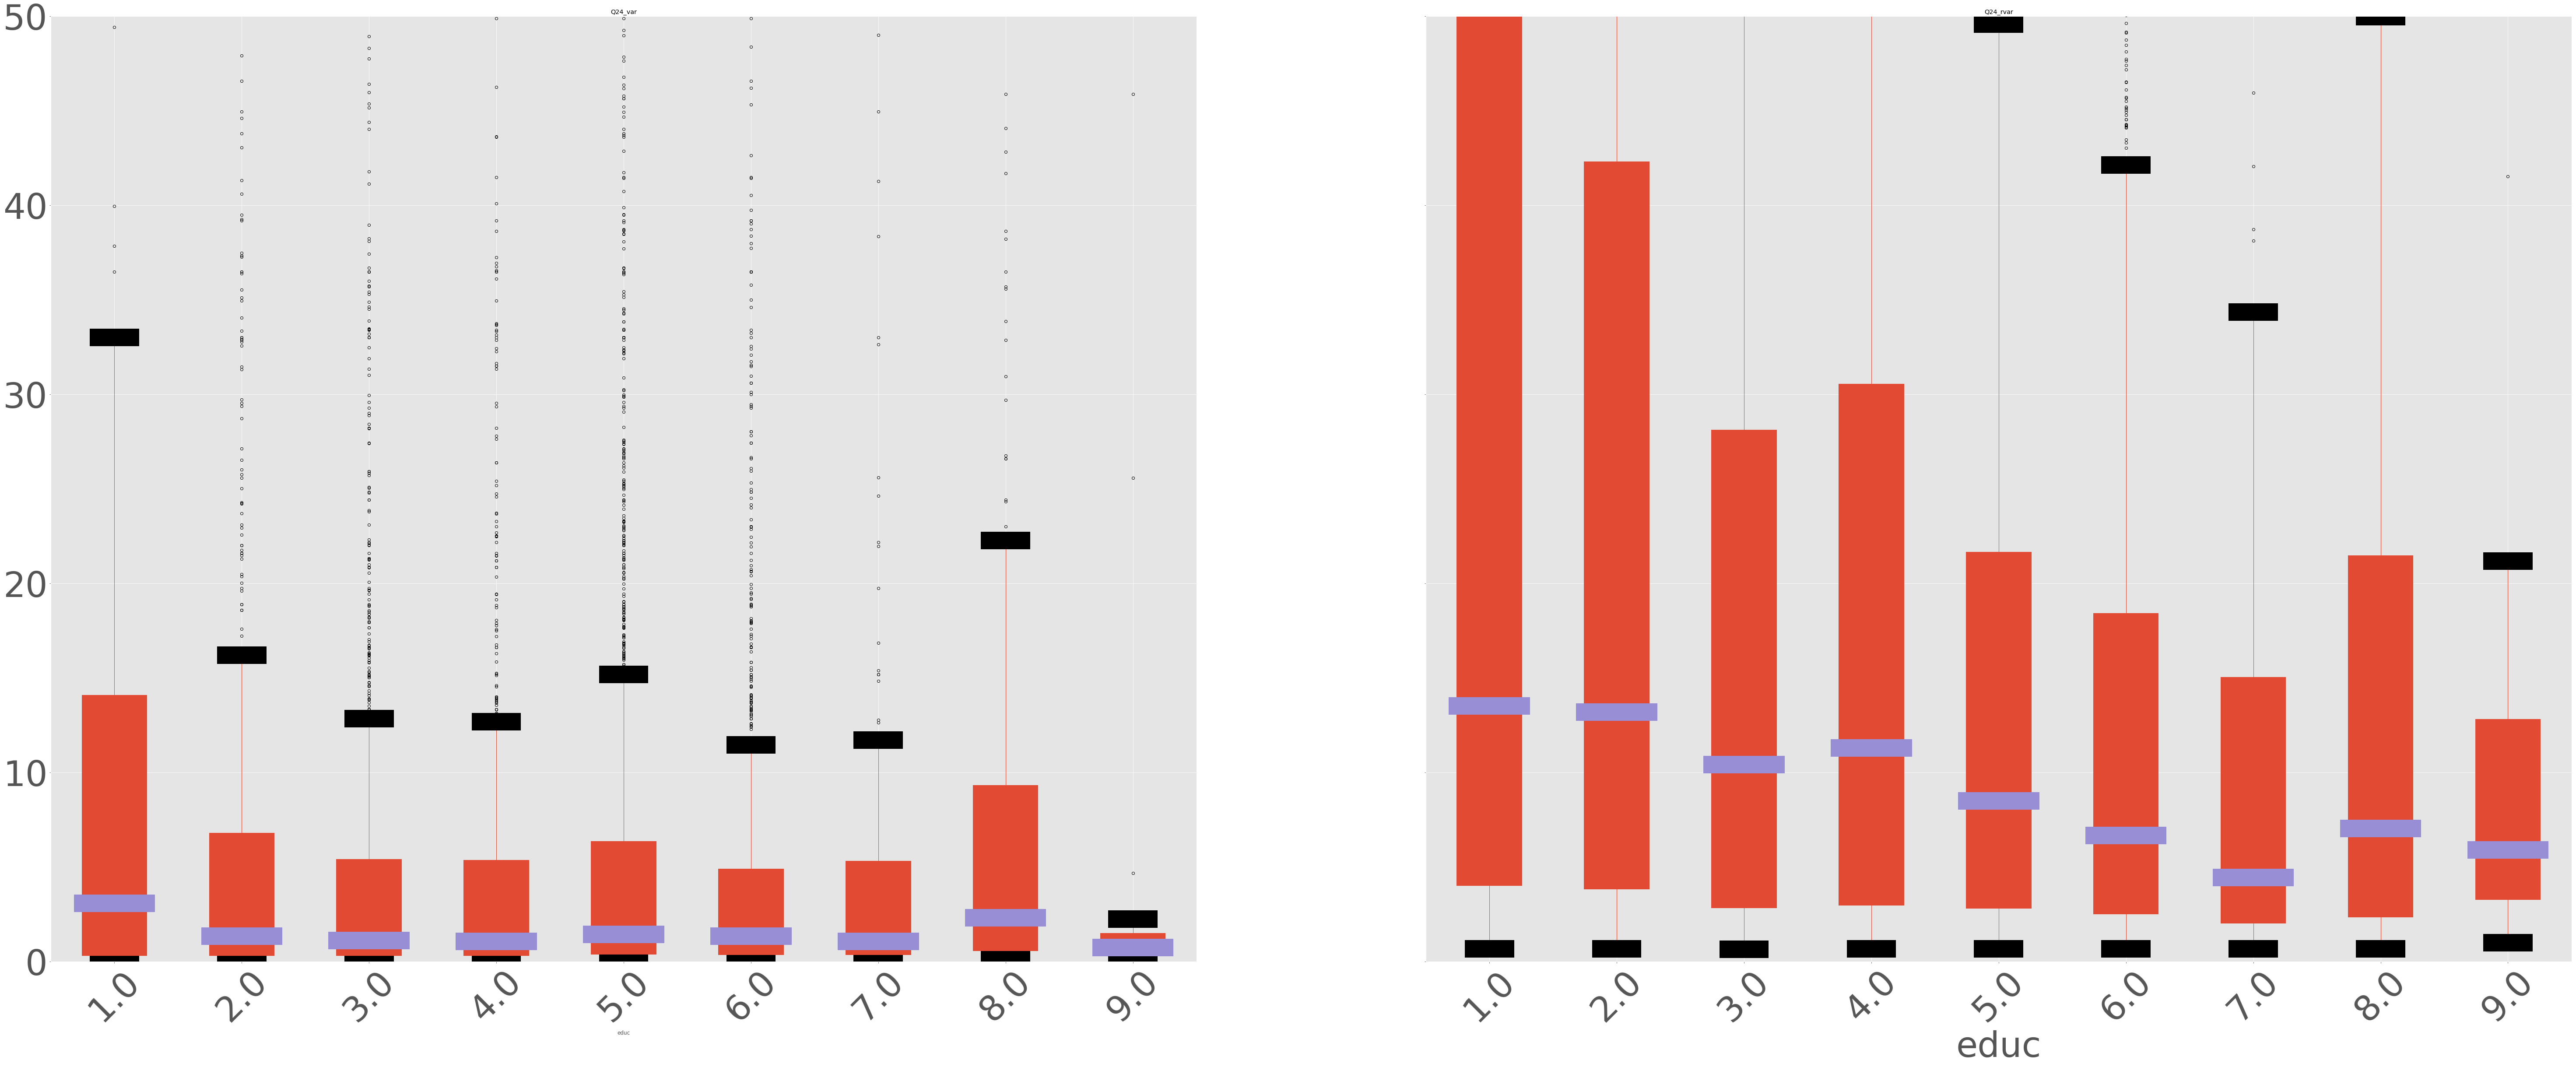

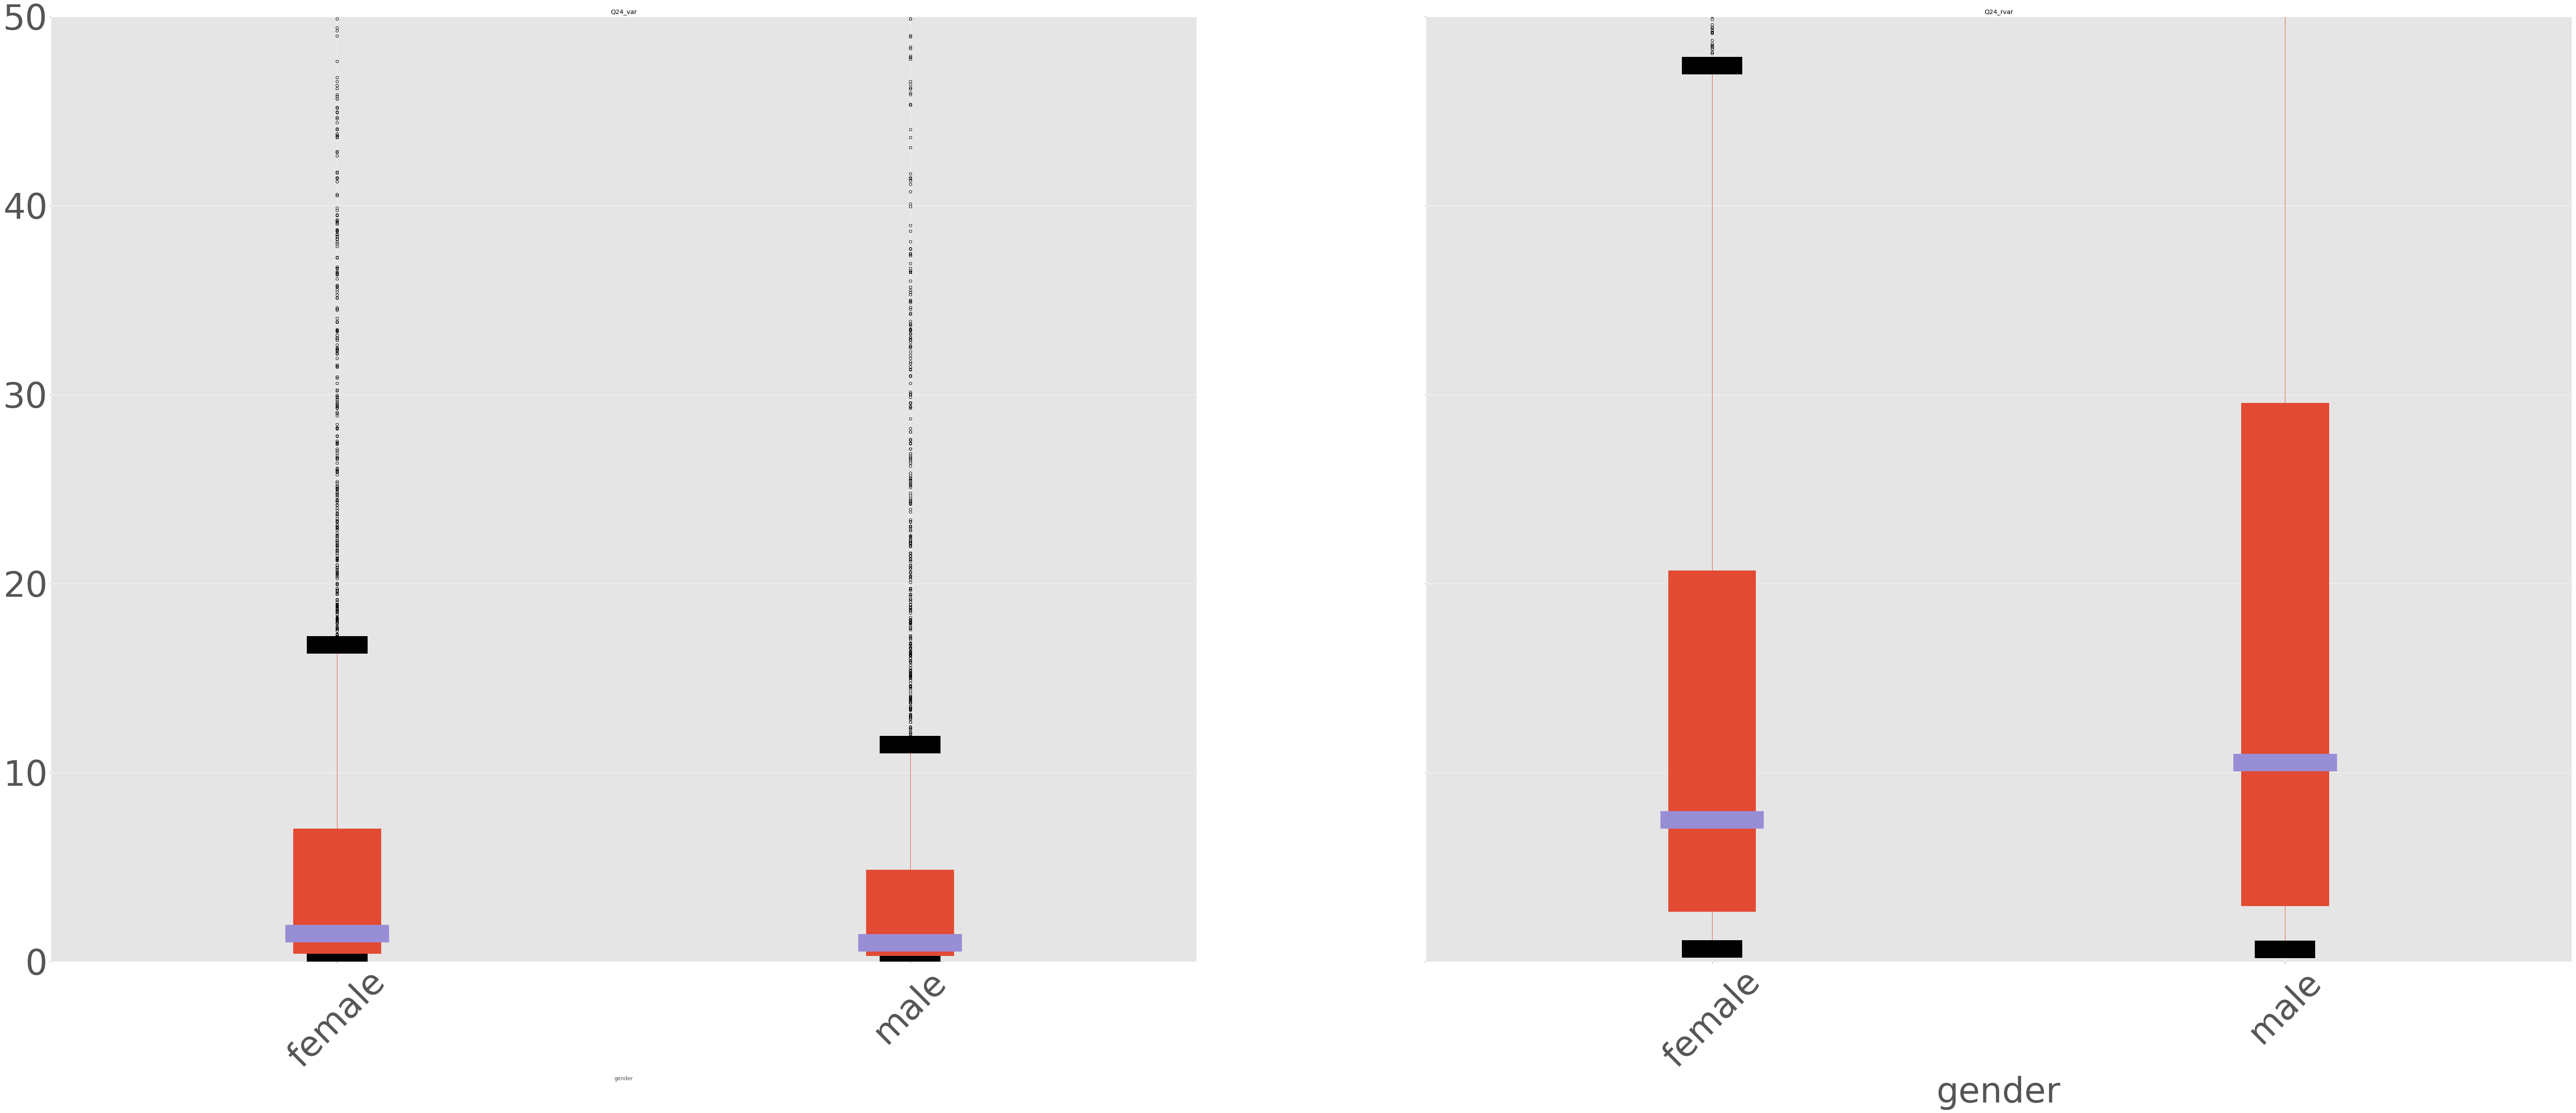

In [14]:
fontsize = 80
figsize = (100,40)
plt.style.use('ggplot')

for gp in ['HHinc','educ','gender']:
    bp = SCEM.boxplot(column=['Q24_var','Q24_rvar'],
                     figsize = figsize,
                     by = gp,
                     patch_artist = True,
                     fontsize = fontsize,
                     layout=(1, 2),
                      rot =45,
                      return_type='dict')
    
    #plt.title(mom, fontsize= fontsize)
    ## adjust width of lines
    [[item.set_linewidth(4) for item in bp[key]['boxes']] for key in bp.keys()]
    [[item.set_linewidth(40) for item in bp[key]['fliers']] for key in bp.keys()]
    [[item.set_linewidth(40) for item in bp[key]['medians']] for key in bp.keys()]
    [[item.set_linewidth(40) for item in bp[key]['means']] for key in bp.keys()]
    #[[item.set_linewidth(40) for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_linewidth(40) for item in bp[key]['caps']] for key in bp.keys()]
    
    ## adjust color 
    #[[item.set_markerfacecolor('r') for item in bp[key]['means']] for key in bp.keys()]
    #[[item.set_color('k') for item in bp[key]['whiskers']] for key in bp.keys()]
    
    plt.xlabel(gp,
               fontsize = fontsize)
    plt.ylabel('var',
               fontsize = fontsize)
    plt.ylim(0,50)
    plt.suptitle('')
    ## save figure 
    plt.savefig('../Graphs/ind/boxplot'+'_'+str(gp)+'.jpg')

###  4. Regressions

What factors are associated with subjective riskiness of labor income? This section inspects the question by regressing the perceived income risks at individual level on three major blocks of variables: job-specific characteristics, household demographics and other macroeconomic expectations held by the respondent. 

In a general form, the regression is specified as followed, where the dependent variable $\textit{IncMom}_{i,t}$ represents alternative measures of perceived income risks for either nominal or real earning. 

\begin{eqnarray}
\textrm{IncMom}_{i,t} = \alpha + \beta_0 \textrm{HH}_{i,t} + \beta_1 \textrm{JobType}_{i,t} + \beta_2 \textrm{Exp}_{i,t} + \beta_3 \textrm{Month}_t + \epsilon_{i,t}
\end{eqnarray}

The first block of factors, as called $\textit{Jobtype}_{i,t}$ includes dummy variables indicating if the job is part-time or if the work is for others or self-employed. Since the earning growth is specifically asked regarding the current job of the individual, I can directly test if a part-time job and the self-employed job is associated with higher perceived risks. 

The second type of factors denoted $\textit{HH}_{i,t}$ represents household-specific demographics such as the household income level, education, and gender of the respondent. 

Third, $\textit{Exp}_{i,t}$ represents other subjective expectations held by the same individual. As far as this paper is concerned, I include the perceived probability of unemployment herself, the probability of stock market rise over and the probability of a higher nationwide unemployment rate. 

$\textit{Month}_t$ is meant to control possible seasonal or month-of-the-year fixed effects. It may well be the case that at a certain point of the time of the year, workers are more likely to learn about news to their future earnings. But as I will show in the following section, such evidence is limited particularly for the higher moments of earnings growth expectations. 

Besides, since many of the regressors are time-invariant household characteristics, I choose not to control household fixed effects in these regressions ($\omega_i$). Throughout all specifications, I cluster standard errors at the household level because of the concern of unobservable household heterogeneity. The regression results are presented in the table below for three measures of perceived income risks, nominal growth variance, nominal growth iqr, and real growth variance. 

[Table of Individual Moments Regression](../Table/mom_ind_reg.cvs)

The regression results are rather intuitive. It confirms that self-employed jobs, workers from low-income households and lower education have higher perceived income risks. In our sample, there are around $15\%$ (6000) of the individuals who report themselves to be self-employed instead of working for others. In the table shown in the appendix, this group of people also has higher expected earnings growth. The effects are statistically and economically significant. Whether a part-time job is associated with higher perceived risk is ambiguous depending on if we control household demographics. At first sight, part-time jobs may be thought of as more unstable. But the exact nature of part-time job varies across different types and populations. It is possible, for instance, that the part-time jobs available to high-income and educated workers bear lower risks than those by the low-income and low-education groups. 

The negative correlation between perceived risks and household income is significant and robust throughout all specifications. In contrast, there is no such correlation between expected earning growth per se and household income. Although SCE asks the respondent to report an income range instead of the accurate monetary value, the 11-group breakdown is sufficiently granular to examine if the high-income/low risks association is monotonic. As implied by the size of the coefficient of each income group dummy in the table, this pattern is monotonically negative until the top income group ($200k or above). I also plot the mean and median of income risks by income group in the figure below.  

[Figure on Perceived Income Risks by Income Group]('../Graphs/ind/riskbyincome.jpg')

Besides household income, there is also statistical correlation between perceived risks and other demographic variables. In particular, higher eduation, being a male versus female, being a middle-aged worker compared to a young, are all associated with lower perceived income risks. To keep a sufficiently large sample size, I run regressions of this set of variables without controling the rest regressors.  Although the sample size shrink substantially by including these demographics, the relationships are statistically significant and consistent across all measures of earning risks. 

Higher perceived the probability of losing the current job, which I call individual unemployment risk, $\textit{IndUE}$ is associated with higher earning risks of the current job. The perceived chance that the nationwide unemployment rate going up next year, which I call aggregate unemployment risk, $\textit{AggUE}$ has a similar correlation with perceived earning risks. Such a positive correlation is important because this implies that a more comprehensively measured income risk facing the individual that incorporates not only the current job's earning risks but also the risk of unemployment is actually higher. Moreover, the perceived risk is higher for those whose perceptions of the earning risk and unemployment risk are more correlated than those less correlated. 

Lastly, what is ambiguous from the regression is the correlation between stock market expectations and perceived income risks. Although a more positive stock market expectation is associated with higher expected earnings growth in both real and nominal terms, it is positively correlated with nominal earning risks but negatively correlated with real earning risks. As the real earning risk is the summation of the perceived risk of nominal earning and inflation uncertainty, the sign difference has to be driven by a negative correlation of expectation stock market and inflation uncertainty.  In order to reach more conclusive statements, in the next section, I will examine how perceived labor income risks correlate with the realized stock market returns and indicators of business cycles.  

To summerize, a few questions arise from the patterns discussed above. First, what drives the differences in subjective earning risks across different workers? To what extent these perceptive differences reflect the true heterogeneity of the income risks facing by these individuals? Or they can be attributed to perceptive heterogeneity independent from the true risk profile. Second, how are individual earning risk is correlated with asset return expectations and broadly the macro economic environment? This will be the focus of the coming sections. 

In [15]:
## regressions try 

dep_list =  moms_nom + moms_real 
indep_list_ct = ['UEprobInd','UEprobInd','Stkprob']
indep_list_dc = ['HHinc','selfemp','fulltime']

rs_list = {}

for i,mom in enumerate(dep_list):
    ct_str = '+'.join([var for var in indep_list_ct])
    dc_str = '+C(HHinc)+C(parttime)+C(selfemp)'
    model = smf.ols(formula = str(mom)
                    +'~ ' + ct_str
                    + dc_str,
                    data = SCEM)
    rs_list[i] = model.fit()
    #print(rs_list[i].summary())
    
## combine different specifications 

rs_names = [rs_list[i] for i in range(len(rs_list))]
dfoutput = summary_col(rs_names,
                       float_format='%0.2f',
                       stars = True,
                       info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                  'R2':lambda x: "{:.2f}".format(x.rsquared)})
dfoutput.title = 'perceived income risks'
#print(dfoutput)

In [16]:
## output tables 

beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}
\\begin{table}"""

endtex = "\end{table}\end{document}"


to_drop = ['Intercept']


In [17]:
## full-table 

rs_list = {}  ## list to store results 
nb_spc = 4  ## number of specifications 

for i,mom in enumerate(dep_list):
    ## model 1 
    model = smf.ols(formula = str(mom)
                    +'~ C(parttime)+C(selfemp)',
                    data = SCEM)
    rs_list[nb_spc*i] = model.fit()
    
    ## model 2
    ct_str = '+'.join([var for var in indep_list_ct])
    model2 = smf.ols(formula = str(mom)
                    +'~ C(parttime)+C(selfemp) + '
                     + ct_str,
                    data = SCEM)
    rs_list[nb_spc*i+1] = model2.fit()
    
    ## model 3 
    model3 = smf.ols(formula = str(mom)
                    +'~ C(parttime) + C(selfemp) + C(HHinc) +'
                     + ct_str,
                    data = SCEM)
    rs_list[nb_spc*i+2] = model3.fit()
    
    ## model 4 
    model4 = smf.ols(formula = str(mom)
                    +'~ C(gender)+ educ',
                    data = SCEM)
    rs_list[nb_spc*i+3] = model4.fit()
    
    
rs_names2 = [rs_list[i] for i in range(len(rs_list))]

dfoutput2 = summary_col(rs_names2,
                        float_format='%0.2f',
                        stars = True,
                        info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                  'R2':lambda x: "{:.2f}".format(x.rsquared)})
dfoutput2.title = 'perceived income risks'
print(dfoutput2)

                                              perceived income risks
                   Q24_var I Q24_var II Q24_var III Q24_var IIII Q24_rvar I Q24_rvar II Q24_rvar III Q24_rvar IIII
------------------------------------------------------------------------------------------------------------------
C(HHinc)[T.<10k]                        4.24***                                         11.33***                  
                                        (0.53)                                          (1.05)                    
C(HHinc)[T.<150k]                       -0.23                                           -1.58***                  
                                        (0.17)                                          (0.33)                    
C(HHinc)[T.<200k]                       -0.07                                           -2.31***                  
                                        (0.22)                                          (0.42)                    
C(HHinc)[T.

In [18]:
## write to latex 
f = open('../Tables/latex/micro_reg.tex', 'w')
f.write(beginningtex)
tb = dfoutput2.tables[0].drop(index = to_drop)
tb_ltx = tb.to_latex()
#print(tb)
f.write(tb_ltx)
f.write(endtex)
f.close()